# ResNet

In [37]:
pip install opencv-python-headless numpy matplotlib tqdm scikit-image


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install torch torchvision


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
pip install seaborn scikit-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 30.9 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [48]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random

from skimage.feature import hog
from skimage import data, exposure

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


import torch.nn as nn
from scipy.spatial.distance import euclidean

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [40]:
data_root_path = "data/UCF-101"

# On a gardé au préalable uniquement les classes nous intéressant
CLASS_NAMES = sorted(os.listdir(data_root_path))
if '.DS_Store' in CLASS_NAMES :
    CLASS_NAMES.remove('.DS_Store')
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [41]:
## Function to extract frames from a video file
def extract_frames_from_video(video_path, frame_rate=5):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

## Function to extract frame data for all videos in the dataset
def extract_dataset_frames(data_root_path, frame_rate=5):
    dataset_frames = {}
    for class_name in tqdm(CLASS_NAMES, desc="Processing classes"):
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        dataset_frames[class_name] = []
        for video_file in tqdm(video_files, desc=f"Processing videos in {class_name}", leave=False):
            video_path = os.path.join(class_path, video_file)
            frames = extract_frames_from_video(video_path, frame_rate)
            dataset_frames[class_name].extend(frames)
    return dataset_frames

def split_dataset(dataset, train_ratio=0.8):
    train_set = {}
    test_set = {}
    for class_name, items in dataset.items():
        random.shuffle(items)
        split_index = int(len(items) * train_ratio)
        train_set[class_name] = items[:split_index]
        test_set[class_name] = items[split_index:]
    return train_set, test_set


In [ ]:
frames_dataset = extract_dataset_frames(data_root_path, frame_rate=5)
train_set, test_set = split_dataset(frames_dataset)

Processing classes: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


## ResNet Computation

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, )
model.fc = nn.Identity()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)
model.eval()
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

mps


## Nearest Centroid

In [46]:
def compute_resnet_centroids(train_set, model, preprocess):
    centroids = {}
    
    with torch.no_grad():
        for class_name, frames in tqdm(train_set.items(), desc="Calculating Centroids"):
            features_list = []
            ## batch processing
            batch_size = 32
            batch = []
            for i, frame in enumerate(frames):
                # Preprocess the frame
                pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
                batch.append(input_tensor)

                # If batch is full or it's the last frame, process it
                if len(batch) == batch_size or i == len(frames) - 1:
                    # Process all frames in the batch
                    batch_tensor = torch.cat(batch, dim=0)
                    feature_vectors = model(batch_tensor).cpu().numpy()
                    features_list.extend(feature_vectors)
                    batch = []  # Reset batch for next iteration
                    
            # Calcul du centroïde pour cette classe
            centroids[class_name] = np.mean(features_list, axis=0)
            
    return centroids

# On calcule les signatures moyennes
class_centroids = compute_resnet_centroids(train_set, model, preprocess)

Calculating Centroids: 100%|██████████| 5/5 [04:11<00:00, 50.27s/it]


In [ ]:
def predict_nearest_centroid(test_set, centroids, model, preprocess):
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for class_name, frames in tqdm(test_set.items(), desc="Predicting"):
            for frame in frames:
                from PIL import Image
                if isinstance(frame, np.ndarray):
                    img = Image.fromarray(frame)
                
                input_tensor = preprocess(img).unsqueeze(0).to(device)
                test_feature = model(input_tensor).cpu().numpy().flatten()
                
                # Trouver la classe la plus proche
                best_class = None
                min_dist = float('inf')
                
                for c_name, centroid_vec in centroids.items():
                    # Distance euclidienne entre le test et le centroïde
                    dist = euclidean(test_feature, centroid_vec)
                    if dist < min_dist:
                        min_dist = dist
                        best_class = c_name
                
                y_true.append(class_name)
                y_pred.append(best_class)
                
    return y_true, y_pred

# Lancement de l'inférence
y_true, y_pred = predict_nearest_centroid(test_set, class_centroids, model, preprocess)

Predicting: 100%|██████████| 5/5 [02:03<00:00, 24.71s/it]


--- Global Performance ---
Accuracy:  0.9506
Precision: 0.9547
Recall:    0.9506
F1-Score:  0.9513



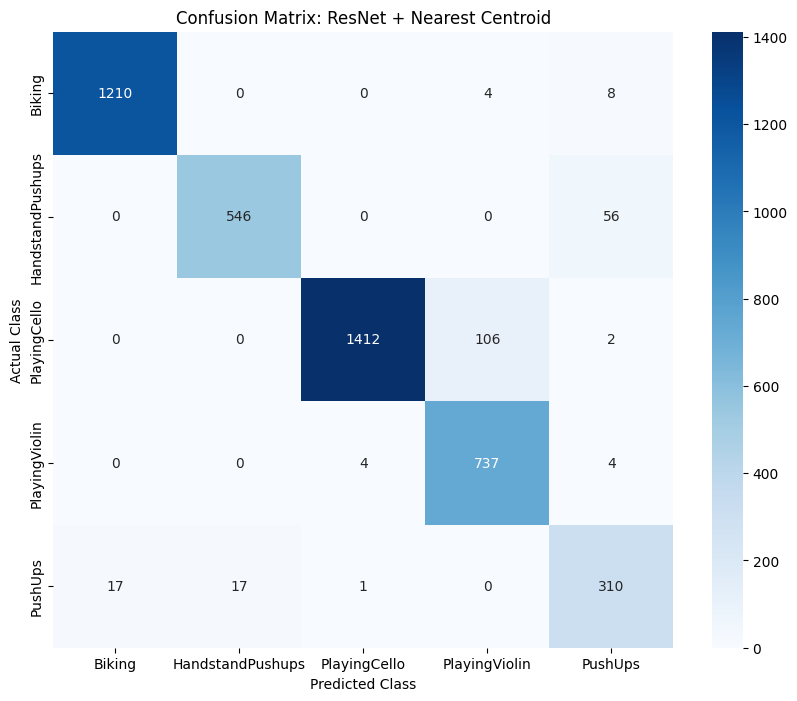

In [49]:
def display_metrics(y_true, y_pred, class_names):
    # 1. Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    # Using 'weighted' average to account for potential class imbalance
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"--- Global Performance ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix: ResNet + Nearest Centroid')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Run the evaluation
display_metrics(y_true, y_pred, CLASS_NAMES)